#Let us visuloize ECG raw with anotations
Database contans total 48 records from 48n ptients each with 30mins record sof holter

Now in database path ../mit-bih_database we have two files
## *.csv file
1. *.csv
2. *.csv conatins values of Y axis i.e amplitude of voltage for each sample.
3. sampleing is done 360 times in a sec that approxmiate to 0.00277777778
4. thee are two cols in CSV one for MLTI and other V5 lead.
so we ploted line  where x axis is sampling each datapoint at 0.00277777778 and y axis is value at MLTI column



## *annotations.txt
1. this file contains the tab seprated data
2. it has 7 columns namely data = {'Time': [], 'Sample #': [], 'Type': [], 'Sub': [], 'Chan': [], 'Num': [], 'Aux': []}
3. Sample columns conatins the valkue of the sample corrsondind to sample count of *.csv
4. Type col contains the Classification types


In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import torch



INPUT_FEATURES =450
BATCH_SIZE =32
SAVE_PREFIX ="Epoch_1_"

device = 'cuda' if torch.cuda.is_available() else 'cpu'


def csv_and_anno(file_name):
  ecg_data = pd.read_csv(f"../mit-bih_database/{file_name}.csv")
  ecg_mlii =  ecg_data.iloc[:, 1]
  annotations_file = f"../mit-bih_database/{file_name}annotations.txt"
  anno_data = {'Time': [], 'Sample #': [], 'Type': [], 'Sub': [], 'Chan': [], 'Num': [], 'Aux': []}
  with open(annotations_file, 'r') as file:
    for line in file:
        # Split the line based on spaces
        parts = line.split()
        # Fill missing values with NaN
        parts += [None] * (7 - len(parts))
        # Assign values to corresponding keys in data dictionary
        anno_data['Time'].append(parts[0])
        anno_data['Sample #'].append(parts[1])
        anno_data['Type'].append(parts[2])
        anno_data['Sub'].append(parts[3])
        anno_data['Chan'].append(parts[4])
        anno_data['Num'].append(parts[5])
        anno_data['Aux'].append(parts[6])

  return ecg_data, ecg_mlii, anno_data


ecg_data, ecg_mlii, anno_data = csv_and_anno(100)

pd.DataFrame(anno_data), pd.DataFrame(ecg_data), ecg_data["'MLII'"][len(ecg_data["'MLII'"])-1]


(           Time Sample # Type   Sub Chan   Num   Aux
 0          Time   Sample    #  Type  Sub  Chan   Num
 1      0:00.050       18    +     0    0     0    (N
 2      0:00.214       77    N     0    0     0  None
 3      0:01.028      370    N     0    0     0  None
 4      0:01.839      662    N     0    0     0  None
 ...         ...      ...  ...   ...  ...   ...   ...
 2270  30:02.717   648978    N     0    0     0  None
 2271  30:03.422   649232    N     0    0     0  None
 2272  30:04.122   649484    N     0    0     0  None
 2273  30:04.817   649734    N     0    0     0  None
 2274  30:05.531   649991    N     0    0     0  None
 
 [2275 rows x 7 columns],
         'sample #'  'MLII'  'V5'
 0                0     995  1011
 1                1     995  1011
 2                2     995  1011
 3                3     995  1011
 4                4     995  1011
 ...            ...     ...   ...
 649995      649995    1009   928
 649996      649996     935   942
 649997      64999

# Create Fiigure of ECG with anoatations

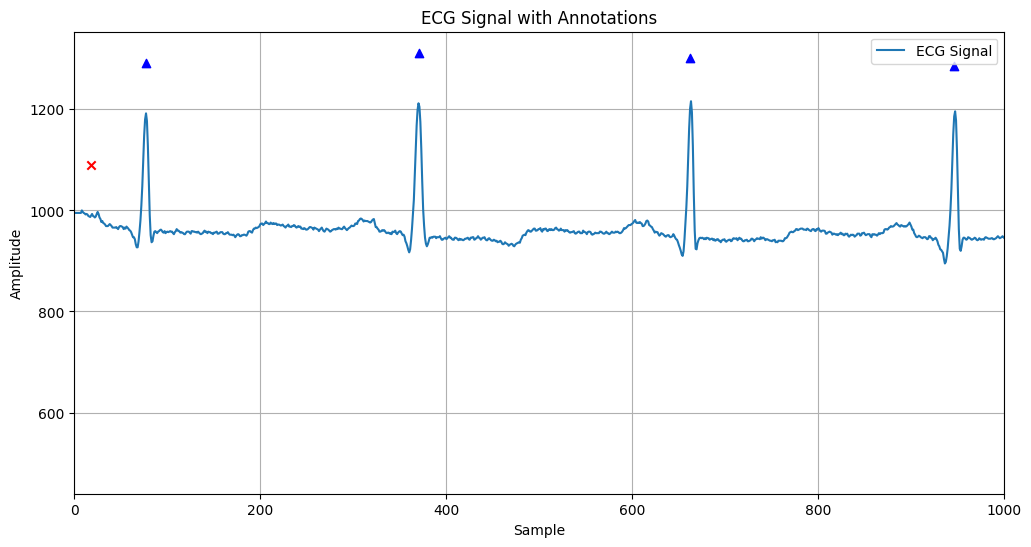

In [7]:



# Plot the ECG signal
plt.figure(figsize=(12, 6))
plt.plot(ecg_mlii, label='ECG Signal')


offset = 100

for i in range(len(anno_data)):
  if i > 0:
    sample_float = int(anno_data["Sample #"][i])
    if anno_data["Type"][i] == 'N':
      plt.scatter(sample_float, ecg_mlii[sample_float] + offset, color='blue', marker='^')
    else:
      # print(i, annotations.iloc[i]["Type"],  annotations.iloc[i]["Sample #"])
      plt.scatter(sample_float,  ecg_mlii[sample_float] + offset , color='red', marker='x')


plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.title('ECG Signal with Annotations')
plt.xlim(0, 1000)
plt.legend()
plt.grid(True)
plt.show()


# WE will look beat by beet with anotatation
hear we will take value of anotation index and one before and one after
and plot


662 1231


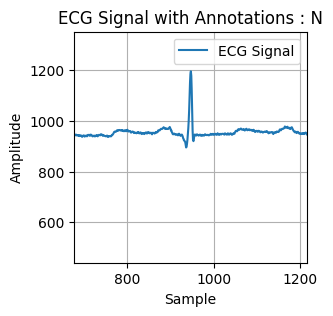

In [8]:
beat_index = 5

before_beat_sample = int(anno_data["Sample #"][beat_index-1])
after_beat_sample = int(anno_data["Sample #"][beat_index+1])
current_beat_sample = int(anno_data["Sample #"][beat_index])
current_beat_type = anno_data["Type"][beat_index]

print(before_beat_sample, after_beat_sample)


before_beat_sample, after_beat_sample, current_beat_type

plt.figure(figsize=(3, 3))
plt.plot(ecg_mlii, label='ECG Signal')
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.title(f'ECG Signal with Annotations : {current_beat_type }')
plt.xlim(before_beat_sample + 15, after_beat_sample -15)
plt.legend()
plt.grid(True)
plt.show()



# get_fixed_length_tensor()
This method for genrateing tensor from the samople heights of single beat
achived by sample form previos beat and after beat

In [9]:
import torch
from torch.nn.functional import pad



def get_fixed_length_tensor(start:int, end:int, ecg_data,fixed_length:int=2000):
  start_plus, end_minus = 15,15
  selected_data = ecg_data.iloc[start + start_plus :end - end_minus, 1]

  tensor_data = torch.tensor(selected_data.values)

  # Pad or truncate the tensor to ensure a fixed length
  if len(tensor_data) < fixed_length:
      # Pad the tensor with zeros to the desired length
      padded_data = pad(tensor_data, (0, fixed_length - len(tensor_data)))
  elif len(tensor_data) > fixed_length:
      # Truncate the tensor to the desired length
      padded_data = tensor_data[:fixed_length]
  else:
      # No need for padding or truncation
      padded_data = tensor_data
  return padded_data.float()

sample_beat_tesnor = get_fixed_length_tensor(before_beat_sample, after_beat_sample, ecg_data)
sample_beat_tesnor.dtype


torch.float32

# def get_csv_files(directory):
this method get csv file names from the database directory
extenions are trimed


In [10]:
import os

def get_csv_files(directory):
    csv_files = []
    for filename in os.listdir(directory):
        if filename.endswith('.csv'):
            csv_files.append(os.path.splitext(filename)[0])  # Exclude file extension
    return csv_files

# Example usage
directory = '../mit-bih_database'
csv_files = get_csv_files(directory)
print(csv_files)


['100', '101', '102', '103', '104', '105', '106', '107', '108', '109', '111', '112', '113', '114', '115', '116', '117', '118', '119', '121', '122', '123', '124', '200', '201', '202', '203', '205', '207', '208', '209', '210', '212', '213', '214', '215', '217', '219', '220', '221', '222', '223', '228', '230', '231', '232', '233', '234']


# def create_tensor(file_name):
this function create in single array

tensor_array = {"tensor": [], "label": []}

In [11]:


tensor_array = {"tensor": [], "label": []}

def create_tensor(file_name):
    ecg_data, ecg_mlii, anno_data = csv_and_anno(file_name)
    data_len = len(anno_data['Sample #'])

    # Process index 1 separately
    start = 0
    end = int(anno_data['Sample #'][1+1])
    tensor_array['tensor'].append(get_fixed_length_tensor(start, end, ecg_data, fixed_length=INPUT_FEATURES))
    tensor_array['label'].append(anno_data['Type'][1])

    # Process the remaining indices
    for i in range(2, data_len - 1):  # Exclude the last data point
        start = int(anno_data['Sample #'][i-1])
        end = int(anno_data['Sample #'][i+1])
        tensor_array['tensor'].append(get_fixed_length_tensor(start, end, ecg_data, fixed_length=INPUT_FEATURES))
        tensor_array['label'].append(anno_data['Type'][i])



for i in range(len(csv_files)):
  create_tensor(csv_files[i])
  print(len(tensor_array['tensor']))

# create_tensor(200)


2273
4146
6337
8427
10737
13427
15524
17663
19486
22020
24152
26701
28496
30385
32346
34766
36304
38604
40697
42572
45050
46568
48201
50992
53030
55175
58282
60953
63337
66376
69427
72111
74873
78166
80462
83861
86140
88451
90519
92980
95613
98255
100395
102860
104870
106685
109836
112599


In [12]:
from collections import Counter

# Assuming tensor_array["label"] contains the list of labels
label_counts = Counter(tensor_array["label"])

# Print the count of each label
for label, count in label_counts.items():
    print(f"Label {label}: Count {count} {100*(count/112599) : .2f}%")


Label +: Count 1291  1.15%
Label N: Count 75016  66.62%
Label A: Count 2544  2.26%
Label V: Count 7130  6.33%
Label ~: Count 616  0.55%
Label |: Count 132  0.12%
Label Q: Count 33  0.03%
Label /: Count 7024  6.24%
Label f: Count 982  0.87%
Label x: Count 193  0.17%
Label F: Count 803  0.71%
Label j: Count 229  0.20%
Label L: Count 8072  7.17%
Label a: Count 150  0.13%
Label J: Count 83  0.07%
Label R: Count 7256  6.44%
Label [: Count 6  0.01%
Label !: Count 472  0.42%
Label ]: Count 6  0.01%
Label E: Count 106  0.09%
Label S: Count 2  0.00%
Label ": Count 437  0.39%
Label e: Count 16  0.01%


# Split Data into training and test data

In [13]:
import sklearn
from sklearn.model_selection import train_test_split

# Assuming you have populated tensor_array with tensors and labels

# Split the data into training and testing sets
train_tensors, test_tensors, train_labels, test_labels = train_test_split(tensor_array['tensor'], tensor_array['label'], test_size=0.2, random_state=42)

# Create new dictionaries for training and testing sets
train_tensor_array = {"tensor": train_tensors, "label": train_labels}
test_tensor_array = {"tensor": test_tensors, "label": test_labels}

# Check the lengths of the training and testing sets
print("Training set length:", len(train_tensors))
print("Testing set length:", len(test_tensors))


unique_labels = set(tensor_array['label'])
print("Unique labels:", unique_labels)
CLASSIFICATION_LENGTH=len(unique_labels)
print(CLASSIFICATION_LENGTH)


Training set length: 90079
Testing set length: 22520
Unique labels: {'A', 'F', '+', '[', '|', 'a', 'x', 'S', 'L', 'N', 'j', ']', '/', '!', '"', 'E', 'R', '~', 'V', 'e', 'Q', 'J', 'f'}
23


# Plot ecg beats from the tensory array by random sampling 3X3

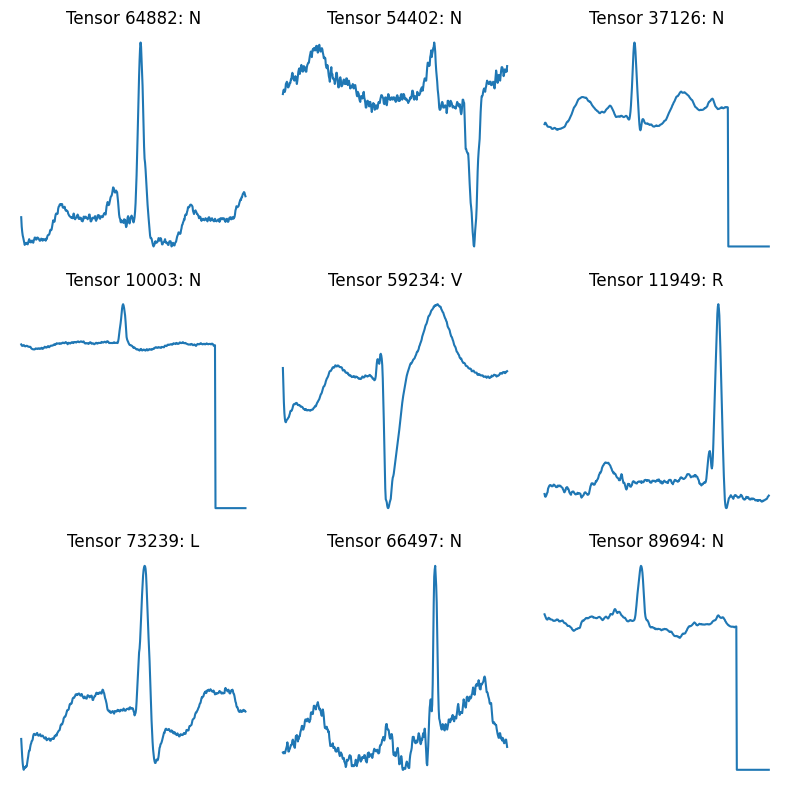

In [14]:

import random

# Get random indices
random_indices = random.sample(range(len(train_tensor_array['tensor'])), 9)


# Create a 3x3 subplot grid
fig, axs = plt.subplots(3, 3, figsize=(8, 8))

# Plot each tensor and label
for i, idx in enumerate(random_indices):
    tensor = train_tensor_array['tensor'][idx]
    label = train_tensor_array['label'][idx]
    x_values = range(len(tensor))

    # Determine the subplot position
    row = i // 3
    col = i % 3

    # Plot the tensor values
    axs[row, col].plot(x_values, tensor.numpy())
    axs[row, col].set_title(f'Tensor {idx}: {label}')
    axs[row, col].axis('off')



# Adjust layout
plt.tight_layout()

plt.show()



# first  and last tesnor plot

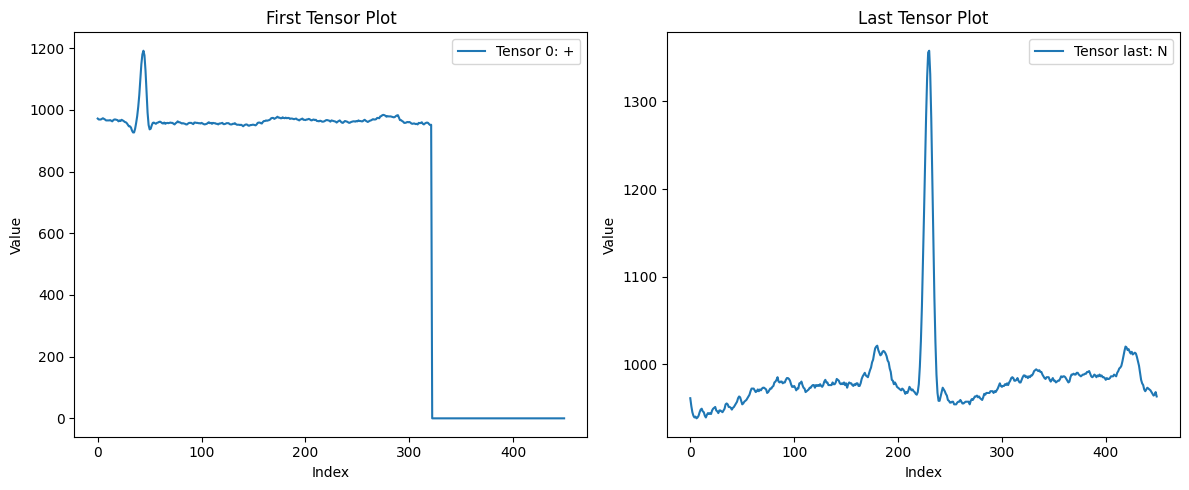

In [15]:
import matplotlib.pyplot as plt

# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# get first and last tensor
tensor_first = tensor_array['tensor'][1]
tensor_last = tensor_array['tensor'][-1]

# Plot the first tensor
label_first = tensor_array['label'][0]
x_values_first = range(len(tensor_first))
axs[0].plot(x_values_first, tensor_first.numpy(), label=f'Tensor 0: {label_first}')
axs[0].set_xlabel('Index')
axs[0].set_ylabel('Value')
axs[0].set_title('First Tensor Plot')


# Plot the last tensor

label_last = tensor_array['label'][-1]
x_values_last = range(len(tensor_last))
axs[1].plot(x_values_last, tensor_last.numpy(), label=f'Tensor last: {label_last}')
axs[1].set_xlabel('Index')
axs[1].set_ylabel('Value')
axs[1].set_title('Last Tensor Plot')


# Show legend
axs[0].legend()
axs[1].legend()

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()


# LinearModel Class

In [16]:
import torch
from torch import nn
class LinearModel(nn.Module):
  def __init__(self, input_features:int, output_feature:int, hidden_units:int=500) -> None:
     super().__init__()
     self.layer= nn.Sequential(
         nn.Linear(in_features=input_features, out_features=hidden_units),
         nn.ReLU(),
         nn.Linear(in_features=hidden_units, out_features=hidden_units),
         nn.ReLU(),
         nn.Linear(in_features=hidden_units, out_features=output_feature),
      )

  def forward(self, x:torch.Tensor)->torch.Tensor:
    return self.layer(x)



model_0 = LinearModel(input_features=INPUT_FEATURES, output_feature=CLASSIFICATION_LENGTH, hidden_units=500).to(device)

model_0


#

LinearModel(
  (layer): Sequential(
    (0): Linear(in_features=450, out_features=500, bias=True)
    (1): ReLU()
    (2): Linear(in_features=500, out_features=500, bias=True)
    (3): ReLU()
    (4): Linear(in_features=500, out_features=23, bias=True)
  )
)

# Res-Net-18 module

In [17]:
import torch
import torch.nn as nn
import torchvision.models as models

# Define a custom ResNet-18 model for your specifications
class CustomResNet18(nn.Module):
    def __init__(self, num_classes):
        super(CustomResNet18, self).__init__()
        self.resnet = models.resnet18(pretrained=False)
        # Replace the first convolutional layer to accept 1 channel instead of 3
        self.resnet.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        # Replace the last fully connected layer
        self.resnet.fc = nn.Linear(self.resnet.fc.in_features, num_classes)

    def forward(self, x):
        return self.resnet(x)

# Create an instance of the custom ResNet-18 model
custom_resnet18 = CustomResNet18(num_classes=23)  # Adjust num_classes to 23

# Example usage:
input_tensor = torch.randn(1, 1, 500, 1)  # Example input tensor with shape [batch_size, channels, height, width]
output = custom_resnet18(input_tensor)
print(output.shape)  # Print the shape of the output tensor

model_0 =  CustomResNet18(num_classes=23)




c:\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


torch.Size([1, 23])


# def accuracy_fn():

In [18]:
# Calculate accuracy (a classification metric)
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100
    return acc

# Custom Dataloader


In [19]:
import torch
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import DataLoader,WeightedRandomSampler
from collections import Counter

class CustomDataset(Dataset):
    def __init__(self, data_array, label_set):
        self.data = data_array['tensor']
        self.labels = data_array['label']
        self.label_to_index = {label: i for i, label in enumerate(label_set)}
        self.index_to_label = {i: label for label, i in self.label_to_index.items()}

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Convert the one-dimensional tensor to the shape [1, 360, 1]
        data_tensor = torch.tensor(self.data[idx], dtype=torch.float32).view(1, INPUT_FEATURES, 1)
        label = self.labels[idx]
        label_tensor = torch.tensor(self.label_to_index[label], dtype=torch.long)  # Use long type for classification labels
        sample = {'tensor': data_tensor, 'label': label_tensor}
        return sample

# weight adjument

In [20]:

# Create custom datasets for training and testing
lable_set = ['Q', 'j', 'f', 'a', '|', 'N', 'S', '!', 'R', 'V', '"', 'L', 'e', 'J', '+', 'F', '[', ']', '~', 'x', 'A', 'E', '/']


# Calculate class weights
label_counts = Counter(tensor_array["label"])
total_samples = sum(label_counts.values())

# class_weights = [total_samples / label_counts[label] for label in lable_set]

class_weights = [total_samples / label_counts[label] if label_counts[label] != 0 else total_samples / 0.00000001 for label in lable_set]


print(class_weights)


# Map each label to its corresponding index
label_to_index = {label: i for i, label in enumerate(lable_set)}

# Create a list of class weights based on the mapped indices
weights = [class_weights[label_to_index[label]] for label in tensor_array["label"]]

# Create a sampler with weighted sampling
sampler = WeightedRandomSampler(weights, len(weights), replacement=True)





# Create data loaders for training and testing
# train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False, sampler=sampler)
# test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False,  sampler=sampler)

[3412.090909090909, 491.69868995633186, 114.66293279022403, 750.66, 853.0227272727273, 1.500999786712168, 56299.5, 238.5572033898305, 15.518054024255788, 15.792286115007013, 257.6636155606407, 13.949331020812686, 7037.4375, 1356.6144578313254, 87.21843532145624, 140.22291407222914, 18766.5, 18766.5, 182.79058441558442, 583.4145077720207, 44.260613207547166, 1062.254716981132, 16.030609339407746]


# Load the data in custom data loader

In [21]:


train_dataset = CustomDataset(train_tensor_array,lable_set)
test_dataset = CustomDataset(test_tensor_array, lable_set)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True )
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32).to(device)
# loss_fn = torch.nn.CrossEntropyLoss(weight=class_weights_tensor)
loss_fn = torch.nn.CrossEntropyLoss()


# Define your loss function with class weights


# Define your optimizer
# optimizer = torch.optim.Adam(custom_resnet18.parameters(), lr=0.001)
optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.1)



# Let's check out what we've created
print(f"train_dataloader.dataset[0].shape {train_dataloader.dataset[0]}")
print(f"Dataloaders: {train_dataloader, test_dataloader}")
print(f"Length of train dataloader: {len(train_dataloader)} batches of {BATCH_SIZE}")
print(f"Length of test dataloader: {len(test_dataloader)} batches of {BATCH_SIZE}")

train_dataloader.dataset[0].shape {'tensor': tensor([[[ 989.],
         [ 988.],
         [ 988.],
         [ 991.],
         [ 996.],
         [ 998.],
         [1000.],
         [ 997.],
         [ 998.],
         [ 996.],
         [ 998.],
         [ 994.],
         [ 993.],
         [ 989.],
         [ 995.],
         [1004.],
         [1013.],
         [1018.],
         [1014.],
         [1009.],
         [1006.],
         [1009.],
         [1008.],
         [1009.],
         [1009.],
         [1007.],
         [1008.],
         [1013.],
         [1018.],
         [1018.],
         [1014.],
         [1011.],
         [1010.],
         [1007.],
         [1012.],
         [1013.],
         [1016.],
         [1016.],
         [1022.],
         [1027.],
         [1030.],
         [1029.],
         [1027.],
         [1024.],
         [1021.],
         [1020.],
         [1023.],
         [1026.],
         [1025.],
         [1023.],
         [1028.],
         [1034.],
         [1039.],
 

C:\Users\ASUS\AppData\Local\Temp\ipykernel_9820\2683473320.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data_tensor = torch.tensor(self.data[idx], dtype=torch.float32).view(1, INPUT_FEATURES, 1)


In [22]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-ce_loss)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * ce_loss

        if self.reduction == 'mean':
            return torch.mean(focal_loss)
        elif self.reduction == 'sum':
            return torch.sum(focal_loss)
        else:
            return focal_loss

# Example usage
loss_fn = FocalLoss(alpha=1, gamma=2)


# Training and Testing Loop

In [23]:
from tqdm.auto import  tqdm
torch.manual_seed(42)




epochs=1



results = {"loss":[], "test_loss":[], "acc":[], "test_acc":[]}

for epoch in tqdm(range(epochs), desc="Epochs"):
  model_0.train()

  loss = 0
  acc =0
  test_loss =0
  test_acc = 0

  for batch in tqdm(train_dataloader, desc="Training Batch"):
    inputs, labels = batch['tensor'], batch['label']
    outputs = model_0(inputs)
    cur_loss = loss_fn(outputs, labels)
    loss += cur_loss.item()
    cur_acc = accuracy_fn(y_pred=outputs.argmax(dim=1), y_true=labels)
    acc +=cur_acc
    optimizer.zero_grad()
    cur_loss.backward()
    optimizer.step()

  # Take avarage of acc and loss per epoch
  loss=loss/len(train_dataloader)
  acc = acc/len(train_dataloader)
  results["loss"].append(loss)
  results["acc"].append(acc)


  model_0.eval();
  with torch.inference_mode():
    for batch_idx, batch in tqdm(enumerate(test_dataloader), desc="Testing Batch", total=len(test_dataloader)):
      inputs, labels = batch['tensor'], batch['label']
      outputs = model_0(inputs)
      cur_test_loss = loss_fn(outputs, labels)
      test_loss += cur_test_loss.item();
      cur_test_acc = accuracy_fn(y_pred=outputs.argmax(dim=1), y_true=labels)
      test_acc += cur_test_acc

    test_loss = test_loss/len(test_dataloader)
    results["test_loss"].append(test_loss)
    test_acc = test_acc/len(test_dataloader)
    results["test_acc"].append(test_acc)


  print(f"Epoch {epoch} Loss {loss:.4f} Acc {acc:.2f}% Test Loss {test_loss:.4f} Test Acc {test_acc:.2f}% ")






Epochs:   0%|          | 0/1 [00:00<?, ?it/s]

Training Batch:   0%|          | 0/2815 [00:00<?, ?it/s]

C:\Users\ASUS\AppData\Local\Temp\ipykernel_9820\2683473320.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data_tensor = torch.tensor(self.data[idx], dtype=torch.float32).view(1, INPUT_FEATURES, 1)


Testing Batch:   0%|          | 0/704 [00:00<?, ?it/s]

Epoch 0 Loss 0.1884 Acc 91.28% Test Loss 1.3205 Test Acc 30.93% 


In [24]:
import pandas as pd

pd.DataFrame(results)


,loss,test_loss,acc,test_acc
0,0.18843,1.320541,91.278792,30.927438


# Saving the module

In [25]:
import os

# Create the folder if it doesn't exist
folder_name = "ecg_module"
if not os.path.exists(folder_name):
    os.makedirs(folder_name)

# Define the file path for saving the model
file_path = os.path.join(folder_name, "custom_resnet18.pth")

# Save the model
torch.save(custom_resnet18.state_dict(), file_path)



# Load the module

In [26]:
import os

# Define the folder and file path
folder_name = "ecg_module"
file_path = os.path.join(folder_name, f"custom_resnet18.pth")

# Check if the file exists
if os.path.exists(file_path):
    # Create an instance of the custom ResNet-18 model
    loaded_model = CustomResNet18(num_classes=23)
    # Load the model state dictionary
    loaded_model.load_state_dict(torch.load(file_path))
    print("Model loaded successfully.")
else:
    print("Model file does not exist.")


c:\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Model loaded successfully.
